In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def AofT(time,T, ai, taui):
    return ai*np.exp(-time/taui)/(1.+np.exp(-T/(2*taui)))

In [9]:
from SimPEG import *
from simpegem1d.Waveform import CausalConv
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat

In [10]:
class LinearSurvey(Survey.BaseSurvey):
    nD = None
    def __init__(self, time, **kwargs): 
        self.time = time
        self.nD = time.size
        
    def projectFields(self, u):
        return u

class LinearProblem(Problem.BaseProblem):

    surveyPair = LinearSurvey

    def __init__(self, mesh, G, **kwargs):
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        self.G = G

    def fields(self, m, u=None):
        return self.G.dot(m)

    def Jvec(self, m, v, u=None):
        return self.G.dot(v)

    def Jtvec(self, m, v, u=None):
        return self.G.T.dot(v)

# Simple exponential basis


$$ \mathbf{A}\mathbf{\alpha} = \mathbf{d}$$

In [11]:
tind = 12
time = np.load('./exampledata/timevtem.npy')[4:]
obs = np.load('./exampledata/souding_weak.npy')[4:]
wave = np.loadtxt('/Users/sgkang/Dropbox/Shared/SeogiDikun/Milligan/Data/7042_106_wform.xyz', skiprows=7)
M = 81
tau = np.logspace(-5, -2, M)

In [12]:
twave = (np.arange(10000)+1)*1e-5
indstart = 4439
indend = 6000
t0_wave = twave[indstart:indend].min()
time_conv= twave[indstart:indend]-t0_wave

In [13]:
time_conv.max()

0.015600000000000003

In [14]:
currentderiv = wave[indstart:indend]
currentderiv[time_conv>4.4e-3] = 0.
current = CausalConv(wave[indstart:indend], np.ones_like(wave[indstart:indend]), time_conv)

In [15]:
time_conv

array([  0.00000000e+00,   1.00000000e-05,   2.00000000e-05, ...,
         1.55800000e-02,   1.55900000e-02,   1.56000000e-02])

(-4.5, 4.5)

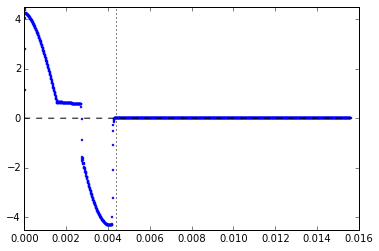

In [16]:
# figsize(6, 4)

plt.plot(time_conv, wave[indstart:indend], 'b.', lw=2, ms=4)
plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[-4.5, 4.5], 'k:')
plt.ylim(-4.5, 4.5)
# plt.xlim(-2e-4, 5.5e-3)

In [17]:
current.min()

3.0000000000009182e-09

(0, 1.0)

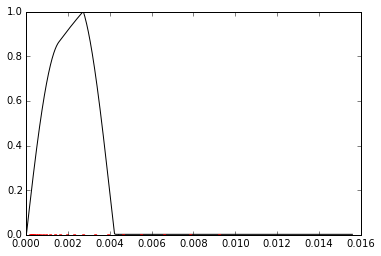

In [18]:
figsize(6, 4)
plt.plot(time_conv, current/current.max(), 'k-')
# plt.plot(time_conv, wave[indstart:indend]*0., 'k--')
plt.plot(np.r_[4.4000000e-03, 4.4000000e-03], np.r_[1e-6, 1e-2], 'k:')
plt.plot(time, np.zeros_like(time), 'r.')
plt.ylim(0, 1.)

In [19]:
from SimPEG import Mesh
from simpegem1d.Waveform import SineFun, SineFunDeriv, CausalConv
dt = 1e-5
t0 = 4.4000000e-03
ntime = time_conv.size
meshtime = Mesh.TensorMesh([dt*np.ones(ntime)], x0=[-dt/2.])
P = meshtime.getInterpolationMat(time+t0, 'CC')
# time_conv = meshtime.gridN
# currentderiv = SineFunDeriv(time_conv, t0)
# current = SineFun(time_conv, t0)

In [20]:
temp = np.exp(-time_conv/1e-2)/1e-2
out = CausalConv(temp, currentderiv, time_conv)
# plt.plot(time_conv, currentderiv)

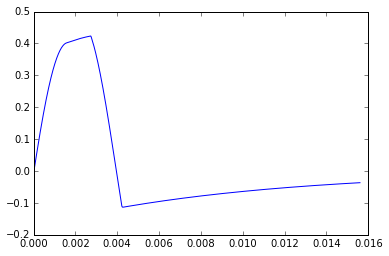

In [21]:
plt.plot(time_conv, out)

In [22]:
time_conv.min(), time_conv.max()

(0.0, 0.015600000000000003)

In [23]:
P.shape

(23, 1561)

In [24]:
N = time.size
A = np.zeros((N, M))
for j in range(M):
    A[:,j] = P*(CausalConv(1./tau[j]*np.exp(-time_conv/tau[j]), -currentderiv, time_conv))

In [25]:
mtrue = np.zeros(M)

In [26]:
np.random.seed(1)
inds = np.random.random_integers(0, 41, size=5)
mtrue[inds] = np.r_[0.1, 2, 1, 4, 5]

In [27]:
out = np.dot(A,mtrue)

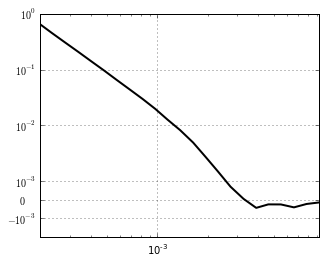

In [28]:
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

# for i, ind in enumerate(inds):
#     temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
#     plt.semilogx(time, temp, 'k', alpha = 0.5)    
outmap, ticks, tickLabels = mapDat(obs,1e-3, stretch=3)    
ax.semilogx(time, outmap, 'k', lw=2)
ax.set_yticks(ticks)
ax.set_yticklabels(tickLabels)
# ax.set_ylim(ticks.min(), ticks.max())
ax.set_xlim(time.min(), time.max())
ax.grid(True)

In [29]:
# from pymatsolver import MumpsSolver

In [30]:
ip = obs[obs<0.]
print obs[obs>0.]/abs(ip).max()

[  1.50625688e+03   1.03992431e+03   7.01240826e+02   4.69947248e+02
   3.17316514e+02   2.17385321e+02   1.49032110e+02   1.01708716e+02
   6.80917431e+01   4.51857798e+01   2.91467890e+01   1.88669725e+01
   1.12522936e+01   6.16972477e+00   3.42660550e+00   1.61009174e+00
   1.07798165e-01]


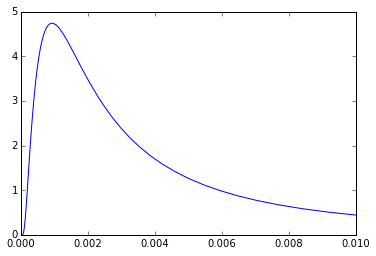

In [31]:
weight = np.sqrt(np.diag(np.dot(A.T, A)))
plt.plot(tau, weight)

In [32]:
from SimPEG import Maps

In [33]:
mesh = Mesh.TensorMesh([M])
wmap = Maps.Weighting(mesh, weights=weight)
prob = LinearProblem(mesh, A)
survey = LinearSurvey(time)
survey.pair(prob)
# survey.makeSyntheticData(mtrue, std=0.01)
# survey.dobs = out
survey.dobs = obs
reg = Regularization.BaseRegularization(mesh, mapping=wmap)
# reg = Regularization.BaseRegularization(mesh)
dmis = DataMisfit.l2_DataMisfit(survey)
# uncert = 0.01*(abs(survey.dobs)+abs(ip).max())
uncert = 0.05*(abs(survey.dobs)+abs(ip).max())
dmis.Wd = 1./(uncert)
opt = Optimization.ProjectedGNCG(maxIter=10)
# opt = Optimization.InexactGaussNewton(maxIter=20)
opt.lower = -1e-10
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 1e-4
beta = Directives.BetaSchedule()
beta.coolingFactor = 1
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
m0 = np.zeros(M)
reg.mref = np.zeros_like(M)
mrec = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.00e-04  3.04e+03  0.00e+00  3.04e+03    1.01e+06      0              
   1  1.00e-04  2.94e+03  9.13e-06  2.94e+03    2.09e+05      3              
   2  1.00e-04  2.88e+03  2.45e-05  2.88e+03    1.59e+05      4   Skip BFGS  
   3  1.00e-04  2.74e+03  1.95e-04  2.74e+03    5.99e+04      2   Skip BFGS  
   4  1.00e-04  2.71e+03  1.10e-03  2.71e+03    1.32e+04      1   Skip BFGS  
   5  1.00e-04  1.24e+03  1.09e-03  1.24e+03    1.76e+04      0              
   6  1.00e-04  1.19e+03  2.31e-03  1.19e+03    4.47e+03      1              
   7  1.00e-04  9.34e+02  5.63e-03  9.34e+02    3.87e+02      0   Skip BFGS  
   8  1

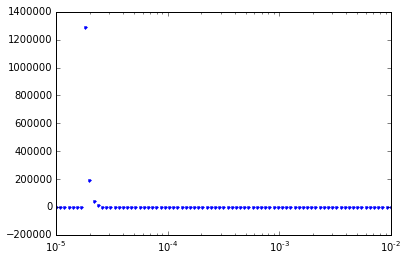

In [34]:
# plt.semilogx(tau, mtrue, '.')
plt.semilogx(tau, mrec, '.')

In [35]:
ip = obs-invProb.dpred
print ip

[-0.03255555  0.01643406  0.01800222  0.00871257  0.00051413 -0.00297504
 -0.00480093 -0.00425742 -0.0028921  -0.00184528 -0.0012905  -0.00028878
  0.00013386  0.00015968  0.00022762  0.00014902 -0.00015768 -0.00050284
 -0.0002683  -0.0002563  -0.00040969 -0.00022709 -0.00014801]


In [36]:
tind = 7
print obs[tind], invProb.dpred[tind], ip[tind]

0.044345 0.0486024217735 -0.00425742177346


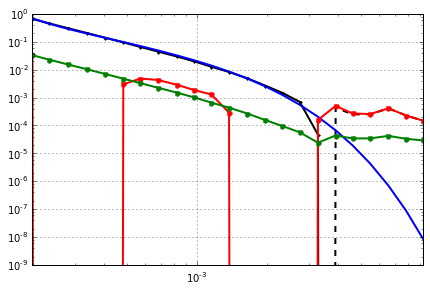

In [37]:
fig = plt.figure(figsize=(7,4.5))
ax = plt.subplot(111)
ax.plot(time, obs, 'k.-', lw=2)
ax.plot(time, -obs, 'k--', lw=2)
ax.plot(time, invProb.dpred, 'b-', lw=2)
ax.plot(time, -ip, 'r.-', lw=2, ms=10)
ax.plot(time, uncert, 'g.-', lw=2, ms=10)
# ax.set_ylim(1e-4, 1e0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(time.min(), time.max())
ax.grid(True)

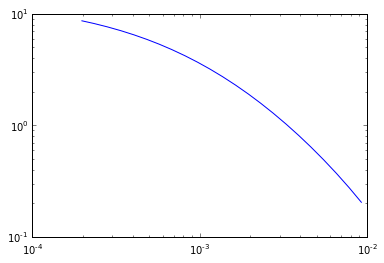

In [62]:
# weight_d = np.sqrt(np.diag(np.dot(np.dot(np.diag(1./uncert), A), (np.dot(np.diag(1./uncert), A)).T)))
weight_d = np.sqrt(np.diag( np.dot(A, A.T)))
plt.loglog(time, weight_d)

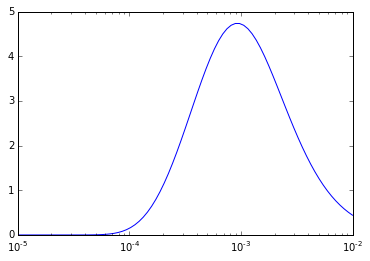

In [63]:
Aw = np.dot(np.diag(1./uncert), A)
weight = np.sqrt( np.diag(np.dot(A.T, A)))
plt.semilogx(tau, weight)